In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import solve, cholesky, inv

%matplotlib inline

In [3]:
n = 50
X_train = np.array([0.1, 2, 3.7])
y_train = np.sin(X_train)

X_test = np.linspace(0, 5, num=n)

In the basic form we have $K_* = k(X, X_*), K_{**} = k(X_*, X_*), K = k(X, X)$, which gives us the following posterior

$$
\begin{align}
    \mu &= K_* K^{-1} y \\
    var &= K_{**} - K_* K^{-1} K_*^T.
\end{align}
$$

We can also write

$$
\begin{align}
    L &= cholesky(K) \\
    \alpha &= L^T \backslash (L \backslash y) \\
    \mu &= K_*^T \alpha \\
    v &= L \backslash K_* \\
    var &= K_{**} - v^T v,
\end{align}
$$

and we also know that

$$
(L \backslash K_*)^T (L \backslash y) = K_*^T (L^T \backslash (L \backslash y)) = K_* K^{-1} y
$$

(50, 30)

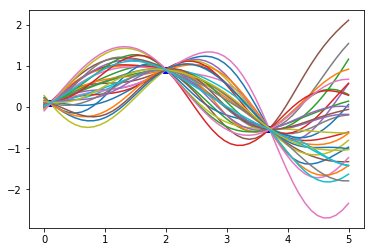

In [4]:
def plots(*plots, n_row=3, figsize=(15,4)):
    num_rows = len(plots) // n_row + 1
      
    plt.figure(figsize=figsize)
        
    for i, plot in enumerate(plots):
        plt.subplot(num_rows, n_row, i+1)
        plt.imshow(plot)
    
    plt.show()

def sqexp(x,y):
    return np.exp(-.5 * 1 * (x*x + y*y - 2*x*y))

def k(x, y=None, kernel=sqexp):
    if y is None:
        y = x
        
    return kernel(*np.meshgrid(y,x)) + 1e-12*np.eye(x.shape[0], y.shape[0])

def gp_reg(X_train, y_train, X_test, kernel):
    n = len(X_test)
    
    K = k(X_train, X_train)
    Kss = k(X_test, X_test)
    Ks = k(X_train, X_test)
    
    K_inv = np.linalg.inv(K + 1e-4 * np.eye(K.shape[0]))

    L = np.linalg.cholesky(K + 1e-4 * np.eye(K.shape[0]))

    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))   # equiv K_inv@y

    mu_post = Ks.T @ alpha
    cov_post = Kss - Ks.T @ K_inv @ Ks

    #Lk = solve(L, Ks)
    #L = np.linalg.cholesky(Kss + 1e-6*np.eye(n) - (Lk.T @ Lk))
    
    #f_post = mu_post.reshape(-1,1) + (cholesky(cov_post) @ np.random.normal(size=(n,3)))
    
    return mu_post, cov_post, cholesky(cov_post)
        
    # plt.plot(mu_post.reshape(-1,1) + np.linalg.cholesky(cov_post) @ np.random.randn(3, 5));
    # y_post = post_mu + np.linalg.cholesky(cov_post) @ np.random.randn()


mu_post, cov_post, L = gp_reg(X_train, y_train, X_test, k)

f_post = mu_post.reshape(-1, 1) + cholesky(cov_post) @ np.random.randn(n, 30)

plt.plot(X_train, y_train, 'bs')
plt.plot(X_test, f_post);
f_post.shape
#plt.plot(f_post)

# plots(Kss, Ks, Ks.T, K)

## GP copied from article

http://krasserm.github.io/2018/03/19/gaussian-processes/

In [5]:
# Taken from https://github.com/krasserm/bayesian-machine-learning/blob/master/gaussian_processes_util.py
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
    ax = plt.gcf().add_subplot(1, 2, i, projection='3d')
    ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
    ax.scatter(X_train[:,0], X_train[:,1], Y_train, c=Y_train, cmap=cm.coolwarm)
    ax.set_title(title)

In [6]:
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2*(X1 @ X2.T)
    return sigma_f ** 2 * np.exp(-0.5 / l**2 * sqdist)

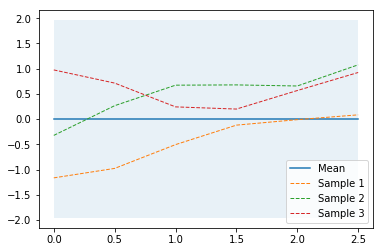

In [7]:
def sqexp(x,y):
    return np.exp(-.5 * 1 * (x*x + y*y - 2*x*y))

def k(x, y=None, kernel=sqexp):
    if y is None:
        y = x
        
    return kernel(*np.meshgrid(y,x)) + 1e-12*np.eye(x.shape[0], y.shape[0])

def linear(x,y):
    return 1 * x * y

X = np.arange(0,3, step=0.5)
mu = np.zeros_like(X)
cov = k(X, X, sqexp)

samps = np.random.multivariate_normal(mu.ravel(), cov, 3)
plot_gp(mu, cov, X, samples=samps)

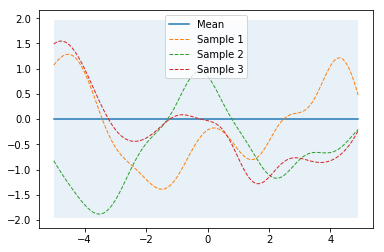

In [8]:
# Finite number of points
X = np.arange(-5, 5, 0.1).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, confidence interval and samples 
plot_gp(mu, cov, X, samples=samples)

In [9]:
def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    mu_s = K_s.T @ K_inv @ Y_train
    cov_s = K_ss - K_s.T @ K_inv @ K_s
    
    return mu_s, cov_s

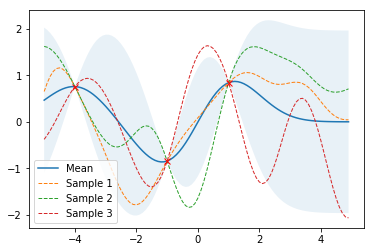

In [10]:
# Noise free training data
X_train = np.array([-4, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)


In [16]:
X.shape

(100, 1)

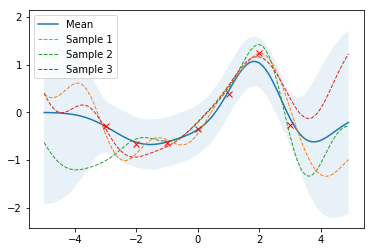

In [11]:
noise = 0.3

# Noisy training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, sigma_y=noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)


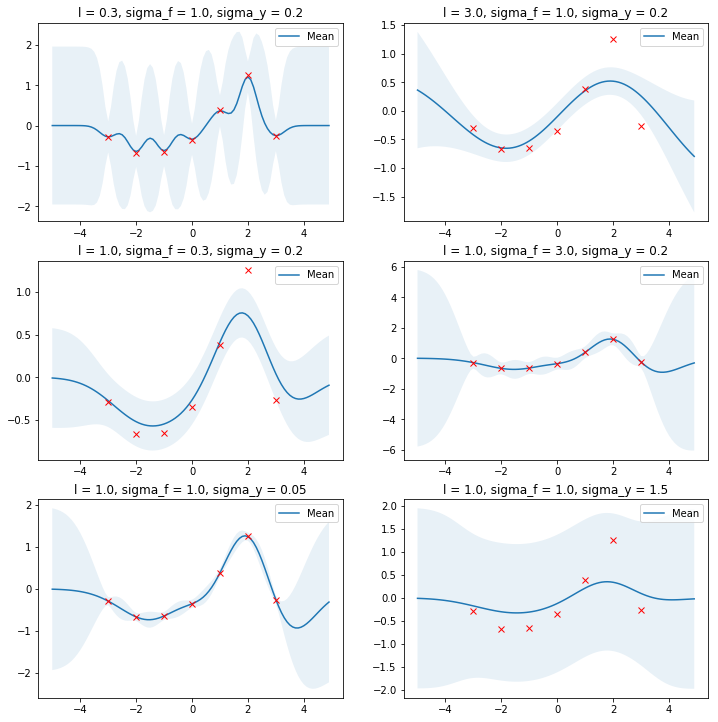

In [12]:
import matplotlib.pyplot as plt

params = [
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
]

plt.figure(figsize=(12, 5))

for i, (l, sigma_f, sigma_y) in enumerate(params):
    mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=l, 
                                       sigma_f=sigma_f, 
                                       sigma_y=sigma_y)
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}, sigma_y = {sigma_y}')
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

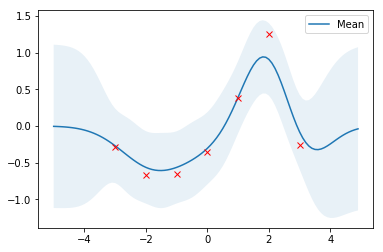

In [13]:
from scipy.optimize import minimize

def nll_fn(X_train, Y_train, noise):
    ''' Returns a function that computes the negative log-likelihood for training data X_train and Y_train and given noise level. Args: X_train: training locations (m x d). Y_train: training targets (m x 1). noise: known noise level of Y_train. Returns: Minimization objective. '''
    def step(theta):
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        # Compute determinant via Cholesky decomposition
        return np.sum(np.log(np.diagonal(cholesky(K)))) + \
               0.5 * Y_train.T.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)
    return step

# Minimize the negative log-likelihood w.r.t. parameters l and sigma_f.
# We should actually run the minimization several times with different
# initializations to avoid local minima but this is skipped here for
# simplicity.
res = minimize(nll_fn(X_train, Y_train, noise), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

# Store the optimization results in global variables so that we can
# compare it later with the results from other implementations.
l_opt, sigma_f_opt = res.x
l_opt, sigma_f_opt

# Compute the prosterior predictive statistics with optimized kernel parameters and plot the results
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=l_opt, sigma_f=sigma_f_opt, sigma_y=noise)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

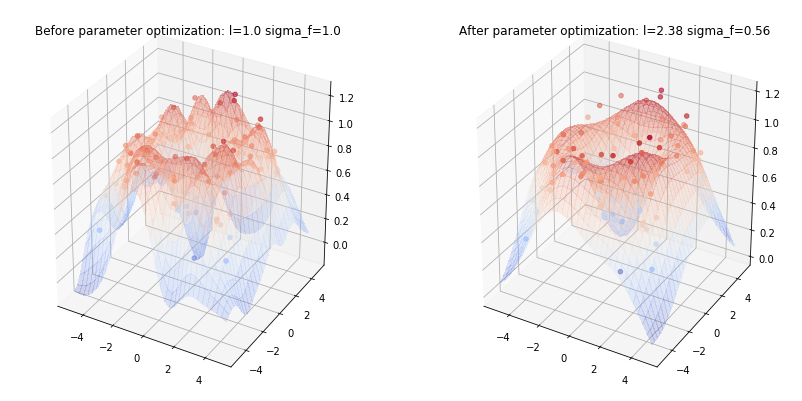

In [14]:
noise_2D = 0.1

rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

X_2D = np.c_[gx.ravel(), gy.ravel()]

X_2D_train = np.random.uniform(-4, 4, (100, 2))
Y_2D_train = np.sin(0.5 * np.linalg.norm(X_2D_train, axis=1)) + \
             noise_2D * np.random.randn(len(X_2D_train))

plt.figure(figsize=(14,7))

mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, sigma_y=noise_2D)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train, 
           f'Before parameter optimization: l={1.00} sigma_f={1.00}', 1)

res = minimize(nll_fn(X_2D_train, Y_2D_train, noise_2D), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, *res.x, sigma_y=noise_2D)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train,
           f'After parameter optimization: l={res.x[0]:.2f} sigma_f={res.x[1]:.2f}', 2)

### Bayesian Optimization

http://krasserm.github.io/2018/03/21/bayesian-optimization/

In [194]:
def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1) 
    plt.plot(X, Y, 'y--', lw=1, label='Noise-free objective')
    plt.plot(X, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()    
        
def plot_convergence(X_sample, Y_sample, n_init=2):
    plt.figure(figsize=(12, 3))

    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x)+1)
    
    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    y_max_watermark = np.maximum.accumulate(y)
    
    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, 'bo-')
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Distance between consecutive x\'s')

    plt.subplot(1, 2, 2)
    plt.plot(r, y_max_watermark, 'ro-')
    plt.xlabel('Iteration')
    plt.ylabel('Best Y')
    plt.title('Value of best selected sample')

In [195]:
bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

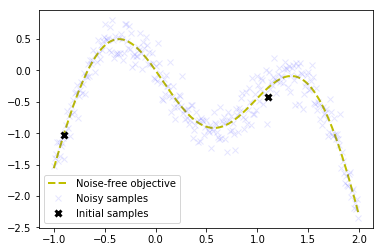

In [196]:
# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

In [197]:
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples
    X_sample and Y_sample using a Gaussian process surrogate model.
    
    Args:
    
    X: Points at which EI shall be computed (m x d).
    X_sample: Sample locations (n x d).
    Y_sample: Sample values (n x 1).
    
    gpr: A GaussianProcessRegressor fitted to samples.
    xi: Exploitation-exploration trade-off parameter.
    
    Returns: Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, X_sample.shape[1])
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [...]
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

In [198]:
from scipy.optimize import minimize

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
    
    acquisition: Acquisition function.
    X_sample: Sample locations (n x d).
    Y_sample: Sample values (n x 1).
    gpr: A GaussianProcessRegressor fitted to samples.
    
    Returns: Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

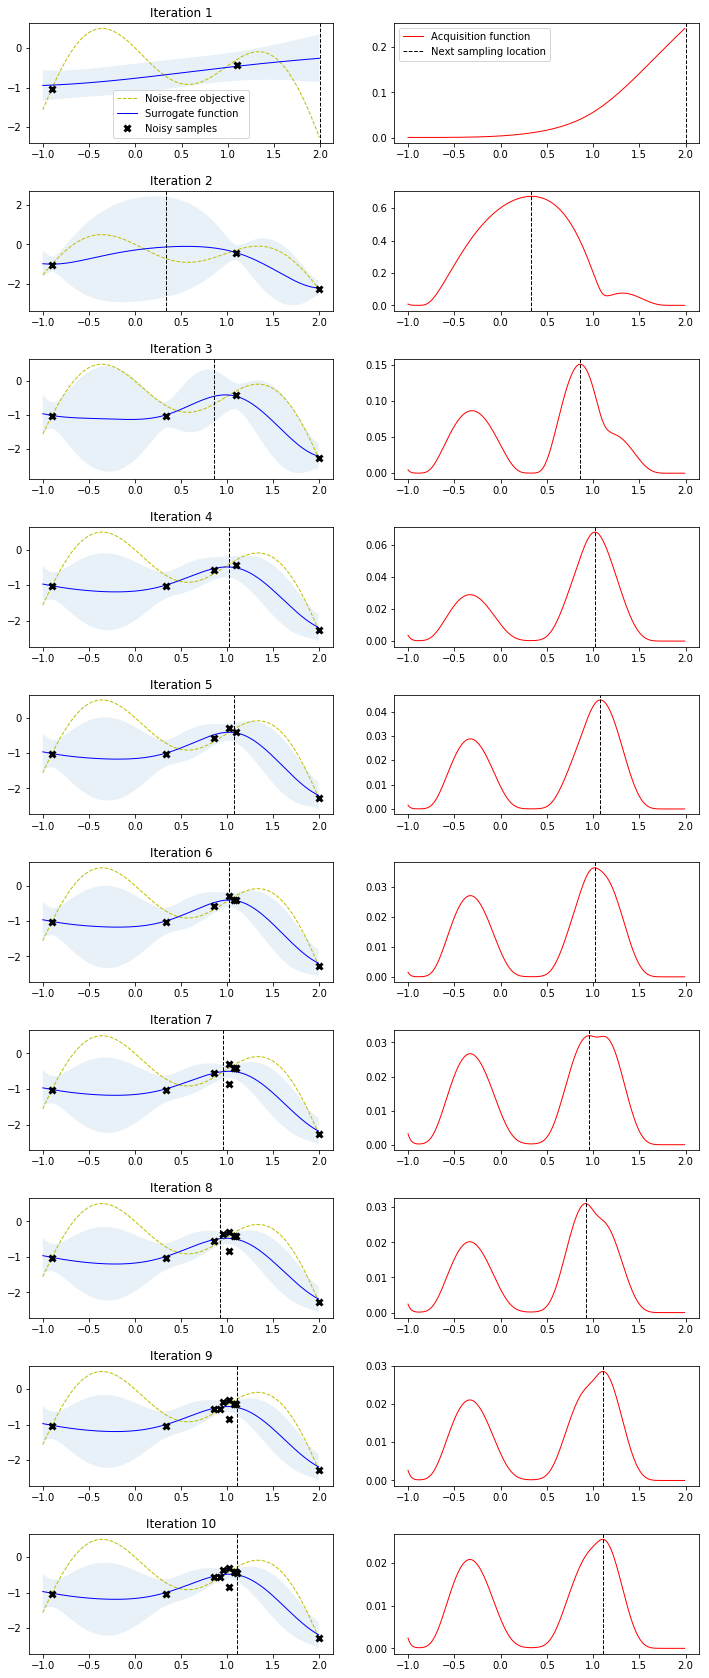

In [200]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

# Gaussian process with Mat??rn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

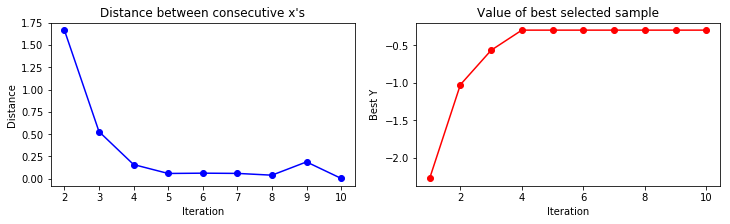

In [201]:
plot_convergence(X_sample, Y_sample)

## More random stuff

In [55]:
a = np.array([[3,1], [1,2]])
b = np.array([9,8])

L = np.linalg.cholesky(a)
# LL'x = b
# Ly = b
# L'x = y
# -> LL'x = b -> Ax = b

x = np.linalg.solve(L.T, np.linalg.solve(L, b))
print(x)

y = np.linalg.inv(L@L.T) @ b
z = np.linalg.inv(a) @ b

print(y)
print(z)

print(np.all(K.T == K))

L = np.linalg.cholesky(K + 1e-12*np.eye(n))
plt.plot(L @ np.random.randn(n, 50));

[2. 3.]
[2. 3.]
[2. 3.]


NameError: name 'K' is not defined

## Random derpings from http://katbailey.github.io/post/gaussian-processes-for-dummies/

In [1]:
# Noiseless training data
Xtrain = np.array([-4, -3, -2, -1, 1]).reshape(5,1)
ytrain = np.sin(Xtrain)

# Apply the kernel function to our training points
K = kernel(Xtrain, Xtrain, param)
K_s = kernel(Xtrain, Xtest, param)



L = np.linalg.cholesky(K)

# Compute the mean at our test points.
Lk = L \ K_s
mu = Lk.T @ (L \ ytrain)

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)

# Draw samples from the posterior at our test points.

Lsamp = np.linalg.cholesky(K_ss - Lk.T @ Lk)
f_post = mu.reshape(-1,1) + Lsamp @ np.random.normal(size=(n,3))



L = np.linalg.cholesky(K)

# Compute the mean at our test points.
Lk = L \ K_s
mu = (L \ K_s)^T @ (L \ ytrain)

mu = K_s @ L.T \ (L \ ytrain)


solve(L, Ks).T @ solve(L, y)
Ks.T @ solve(L.T, solve(L, y))

Ks.T @ np.linalg.inv(K) @ y

SyntaxError: unexpected character after line continuation character (<ipython-input-1-e40b8859cd57>, line 14)